# Event based

## Import packages 

In [3]:
from cartopy import config
import cartopy
import cartopy.crs as ccrs
import climtas
import cmocean
import dask.array
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy import stats
from scipy.stats import ttest_ind 
import seaborn as sns
import sparse
import xarray as xr

## Identifying heatwave events

In [1]:
#Point of interest for heatwave events in Ningaloo
lat = -22.25
lon = 113.75

In [4]:
# opening the input files with heatwave severity data 
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc').sel(latitude=lat, longitude=lon, method='nearest')
mhw = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus-ocean-sev-2.nc').sel(latitude=lat, longitude=lon, method='nearest')

In [5]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 3 consecutive days 
thw_events = climtas.event.find_events(thw.severity > 1, min_duration = 3)

In [6]:
# Create a sparse array with (coords, values, shape)
event_duration_array = sparse.COO(thw_events['time'], thw_events['event_duration'], shape=thw.severity.shape)
event_duration_da = xr.DataArray(event_duration_array, coords=thw.severity.coords)
event_duration_da

Format,coo
Data Type,int64
Shape,"(13514,)"
nnz,188
Density,0.013911499186029302
Read-only,True
Size,2.9K
Storage ratio,0.0


In [7]:
def get_coords(da, events):
    # Convert the index values to coordinates
    coords = {}
    for d in da.dims:
        coords[d] = da[d].values[events[d].values]
    
    # Also work out when the event ends
    coords['time_end'] = da['time'].values[events['time'].values + events['event_duration'].values-1]
    #coords['event_duration'] = coords['time_end'] - coords['time'] 
    coords['event_duration'] = events['event_duration'].values
    
    return pd.DataFrame(coords, index=events.index)

In [8]:
thw_new_H = get_coords(event_duration_da, thw_events)
thw_new_H

,time,time_end,event_duration
0,1982-01-16,1982-01-18,3
1,1982-05-10,1982-05-12,3
2,1982-08-20,1982-08-22,3
3,1982-11-28,1982-12-01,4
4,1983-05-28,1983-05-30,3
...,...,...,...
183,2018-03-07,2018-03-11,5
184,2018-04-04,2018-04-06,3
185,2018-08-17,2018-08-19,3
186,2018-09-23,2018-09-25,3


In [9]:
# using climtas.event.find_events to identify days where severity>1 for a minimum of 5 consecutive days (MHW events)
mhw_events = climtas.event.find_events(mhw.severity > 1, min_duration = 5)

In [10]:
mhw_duration_array = sparse.COO(mhw_events['time'], mhw_events['event_duration'], shape=mhw.severity.shape)
mhw_duration_da = xr.DataArray(event_duration_array, coords=mhw.severity.coords)
mhw_duration_da

Format,coo
Data Type,int64
Shape,"(13514,)"
nnz,188
Density,0.013911499186029302
Read-only,True
Size,2.9K
Storage ratio,0.0


In [11]:
mhw_new = get_coords(mhw_duration_da, mhw_events)
mhw_new

,time,time_end,event_duration
0,1982-03-16,1982-03-20,5
1,1982-04-29,1982-05-10,12
2,1982-08-07,1982-08-21,15
3,1982-10-17,1982-10-25,9
4,1982-11-20,1982-12-08,19
...,...,...,...
125,2016-12-15,2016-12-22,8
126,2017-02-26,2017-03-09,12
127,2017-09-12,2017-09-17,6
128,2018-01-17,2018-01-22,6


In [12]:
mhw_new.rename(columns={"time": "time_mhw", "time_end": "time_end_mhw", "event_duration": "event_duration_mhw"}, inplace=True)
mhw_new

,time_mhw,time_end_mhw,event_duration_mhw
0,1982-03-16,1982-03-20,5
1,1982-04-29,1982-05-10,12
2,1982-08-07,1982-08-21,15
3,1982-10-17,1982-10-25,9
4,1982-11-20,1982-12-08,19
...,...,...,...
125,2016-12-15,2016-12-22,8
126,2017-02-26,2017-03-09,12
127,2017-09-12,2017-09-17,6
128,2018-01-17,2018-01-22,6


In [13]:
# concatenating the THW and MHW dataframes 
df_merge_col = pd.concat([thw_new_H, mhw_new], axis=1)
df_merge_col

,time,time_end,event_duration,time_mhw,time_end_mhw,event_duration_mhw
0,1982-01-16,1982-01-18,3,1982-03-16,1982-03-20,5.0
1,1982-05-10,1982-05-12,3,1982-04-29,1982-05-10,12.0
2,1982-08-20,1982-08-22,3,1982-08-07,1982-08-21,15.0
3,1982-11-28,1982-12-01,4,1982-10-17,1982-10-25,9.0
4,1983-05-28,1983-05-30,3,1982-11-20,1982-12-08,19.0
...,...,...,...,...,...,...
183,2018-03-07,2018-03-11,5,NaT,NaT,NaN
184,2018-04-04,2018-04-06,3,NaT,NaT,NaN
185,2018-08-17,2018-08-19,3,NaT,NaT,NaN
186,2018-09-23,2018-09-25,3,NaT,NaT,NaN


In [14]:
#Calculating the overlap between THW and MHW events 
from datetime import datetime
from collections import namedtuple
Range = namedtuple('Range', ['start', 'end'])
overlap = []
for n in range (df_merge_col.shape[0]):
    mhw = Range(start=df_merge_col['time_mhw'].iloc[n], end=df_merge_col['time_end_mhw'].iloc[n])
    thw = Range(start=df_merge_col['time'].iloc[n], end=df_merge_col['time_end'].iloc[n])
    latest_start = max(mhw.start, thw.start)
    earliest_end = min(mhw.end, thw.end)
    delta = (earliest_end - latest_start).days + 1
    b = max(0, delta)
    overlap.append(b)

In [15]:
mod_fd = df_merge_col.assign(overlap_days = overlap)
mod_fd

,time,time_end,event_duration,time_mhw,time_end_mhw,event_duration_mhw,overlap_days
0,1982-01-16,1982-01-18,3,1982-03-16,1982-03-20,5.0,0
1,1982-05-10,1982-05-12,3,1982-04-29,1982-05-10,12.0,1
2,1982-08-20,1982-08-22,3,1982-08-07,1982-08-21,15.0,2
3,1982-11-28,1982-12-01,4,1982-10-17,1982-10-25,9.0,0
4,1983-05-28,1983-05-30,3,1982-11-20,1982-12-08,19.0,0
...,...,...,...,...,...,...,...
183,2018-03-07,2018-03-11,5,NaT,NaT,NaN,0
184,2018-04-04,2018-04-06,3,NaT,NaT,NaN,0
185,2018-08-17,2018-08-19,3,NaT,NaT,NaN,0
186,2018-09-23,2018-09-25,3,NaT,NaT,NaN,0


## Co-occurring events 

In [17]:
#a co-occurring event is a THW event which has a minimum overlap of 1 day with a MHW
co_events = mod_fd[mod_fd.overlap_days != 0].reset_index()
co_events

,index,time,time_end,event_duration,time_mhw,time_end_mhw,event_duration_mhw,overlap_days
0,1,1982-05-10,1982-05-12,3,1982-04-29,1982-05-10,12.0,1
1,2,1982-08-20,1982-08-22,3,1982-08-07,1982-08-21,15.0,2
2,12,1984-06-13,1984-06-18,6,1984-05-29,1984-06-17,20.0,5
3,18,1985-04-05,1985-04-08,4,1985-04-01,1985-04-05,5.0,1
4,28,1988-07-30,1988-08-04,6,1988-07-27,1988-08-16,21.0,6
5,29,1988-08-30,1988-09-01,3,1988-08-23,1988-09-03,12.0,3
6,32,1988-10-24,1988-10-26,3,1988-10-21,1988-10-28,8.0,3
7,43,1991-08-06,1991-08-14,9,1991-08-11,1991-08-30,20.0,4


In [18]:
del co_events['time_mhw']
del co_events['time_end_mhw']
del co_events['overlap_days']
del co_events['event_duration_mhw']

co_events

,index,time,time_end,event_duration
0,1,1982-05-10,1982-05-12,3
1,2,1982-08-20,1982-08-22,3
2,12,1984-06-13,1984-06-18,6
3,18,1985-04-05,1985-04-08,4
4,28,1988-07-30,1988-08-04,6
5,29,1988-08-30,1988-09-01,3
6,32,1988-10-24,1988-10-26,3
7,43,1991-08-06,1991-08-14,9


In [19]:
# MSLP anomalies 

ds = xr.open_mfdataset('/g/data/e14/cp3790/Charuni/Heatwaves/mslp_anom.nc')
mslp_anom = ds['mslp_anomaly']

In [20]:
mslpa_co = xr.DataArray(np.zeros((co_events.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_co['lat'] = mslp_anom['latitude'].values
mslpa_co['lon'] = mslp_anom['longitude'].values
mslpa_co['event'] = co_events.index.values

In [21]:
for i, e in enumerate(co_events.itertuples()):
    mslpa_co[i, :, :] = mslp_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [22]:
# SST anomalies 

files = glob.glob('/g/data/e14/cp3790/Charuni/MHW-sev/mhw_severity.pc90.*.nc')
sst = xr.open_mfdataset(files, combine='by_coords').sel(time=slice('1985', '2019'), lon=slice(90, 180), lat=slice(-60, 0))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 01-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [23]:
ssta = sst.ssta

In [24]:
ssta_co = xr.DataArray(np.zeros((co_events.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_co['lat'] = ssta['lat'].values
ssta_co['lon'] = ssta['lon'].values
ssta_co['event'] = co_events.index.values

In [25]:
for i, e in enumerate(co_events.itertuples()):
    ssta_co[i, :, :] = ssta.sel(time=slice(e.time, e.time_end)).mean('time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


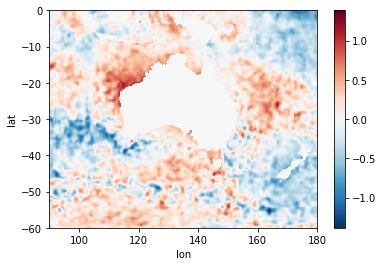

In [26]:
ssta_co.mean(dim='event').plot()

In [27]:
# wind anomalies 

ds2 = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/uwind_anom.nc')
uwind_anom = ds2.uwind_anomaly 
ds3 = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/vwind_anom.nc')
vwind_anom = ds3.vwind_anomaly

In [28]:
uwind_co = xr.DataArray(np.zeros((co_events.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_co['lat'] = uwind_anom['latitude'].values
uwind_co['lon'] = uwind_anom['longitude'].values
uwind_co['event'] = co_events.index.values

In [29]:
for i, e in enumerate(co_events.itertuples()):
    uwind_co[i, :, :] = uwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [30]:
vwind_co = xr.DataArray(np.zeros((co_events.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_co['lat'] = vwind_anom['latitude'].values
vwind_co['lon'] = vwind_anom['longitude'].values
vwind_co['event'] = co_events.index.values

In [31]:
for i, e in enumerate(co_events.itertuples()):
    vwind_co[i, :, :] = vwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [32]:
x = uwind_anom['longitude']
y = vwind_anom['latitude']

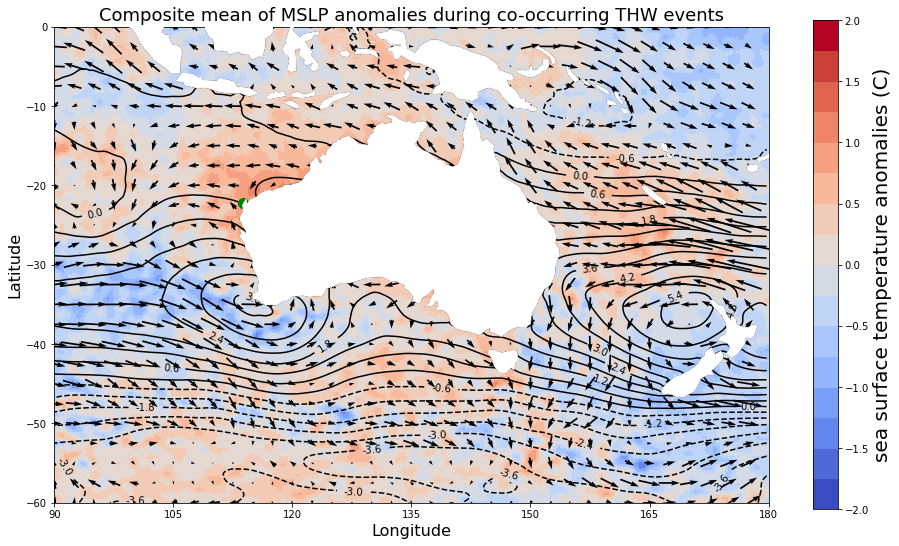

In [33]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=ssta_co.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-2.0, vmax=2.0, # Minimum and maximum values of the colormap
       )

ploteo2=mslpa_co.mean(dim='event').plot.contour(
            colors='k',
            levels=20
       )

ploteo.colorbar.ax.set_ylabel('sea surface temperature anomalies (C)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
ax.quiver(x[::10], y[::10], uwind_co.mean(dim='event')[::10, ::10], vwind_co.mean(dim='event')[::10, ::10], pivot='middle')
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of MSLP anomalies during co-occurring THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/mslpa-co.png')

## Stand-alone events 

In [34]:
#stand-alone events is where there NO overlap between THW and MHW events
stand_alone = mod_fd[mod_fd.overlap_days == 0].reset_index()
stand_alone

,index,time,time_end,event_duration,time_mhw,time_end_mhw,event_duration_mhw,overlap_days
0,0,1982-01-16,1982-01-18,3,1982-03-16,1982-03-20,5.0,0
1,3,1982-11-28,1982-12-01,4,1982-10-17,1982-10-25,9.0,0
2,4,1983-05-28,1983-05-30,3,1982-11-20,1982-12-08,19.0,0
3,5,1983-08-06,1983-08-10,5,1983-01-11,1983-01-17,7.0,0
4,6,1983-09-17,1983-09-20,4,1983-06-10,1983-06-15,6.0,0
...,...,...,...,...,...,...,...,...
175,183,2018-03-07,2018-03-11,5,NaT,NaT,NaN,0
176,184,2018-04-04,2018-04-06,3,NaT,NaT,NaN,0
177,185,2018-08-17,2018-08-19,3,NaT,NaT,NaN,0
178,186,2018-09-23,2018-09-25,3,NaT,NaT,NaN,0


In [35]:
del stand_alone['time_mhw']
del stand_alone['time_end_mhw']
del stand_alone['overlap_days']
del stand_alone['event_duration_mhw']

stand_alone

,index,time,time_end,event_duration
0,0,1982-01-16,1982-01-18,3
1,3,1982-11-28,1982-12-01,4
2,4,1983-05-28,1983-05-30,3
3,5,1983-08-06,1983-08-10,5
4,6,1983-09-17,1983-09-20,4
...,...,...,...,...
175,183,2018-03-07,2018-03-11,5
176,184,2018-04-04,2018-04-06,3
177,185,2018-08-17,2018-08-19,3
178,186,2018-09-23,2018-09-25,3


In [36]:
# MSLP anomalies 

mslpa_nco = xr.DataArray(np.zeros((stand_alone.shape[0], mslp_anom.shape[1], mslp_anom.shape[2])), dims=['event', 'lat', 'lon'])
mslpa_nco['lat'] = mslp_anom['latitude'].values
mslpa_nco['lon'] = mslp_anom['longitude'].values
mslpa_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    mslpa_nco[i, :, :] = mslp_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [37]:
# SST anomalies 

ssta_nco = xr.DataArray(np.zeros((stand_alone.shape[0], ssta.shape[1], ssta.shape[2])), dims=['event', 'lat', 'lon'])
ssta_nco['lat'] = ssta['lat'].values
ssta_nco['lon'] = ssta['lon'].values
ssta_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ssta_nco[i, :, :] = ssta.sel(time=slice(e.time, e.time_end)).mean('time')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

In [38]:
# wind anomalies 

uwind_nco = xr.DataArray(np.zeros((stand_alone.shape[0], uwind_anom.shape[1], uwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
uwind_nco['lat'] = uwind_anom['latitude'].values
uwind_nco['lon'] = uwind_anom['longitude'].values
uwind_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    uwind_nco[i, :, :] = uwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [39]:
vwind_nco = xr.DataArray(np.zeros((stand_alone.shape[0], vwind_anom.shape[1], vwind_anom.shape[2])), dims=['event', 'lat', 'lon'])
vwind_nco['lat'] = vwind_anom['latitude'].values
vwind_nco['lon'] = vwind_anom['longitude'].values
vwind_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    vwind_nco[i, :, :] = vwind_anom.sel(time=slice(e.time, e.time_end)).mean('time')

In [40]:
x = uwind_anom['longitude']
y = vwind_anom['latitude']

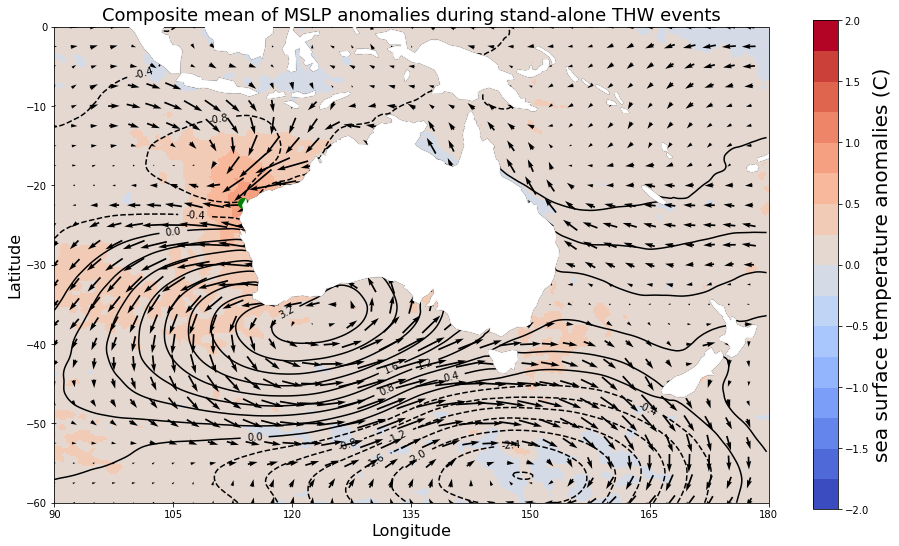

In [41]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=ssta_nco.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-2.0, vmax=2.0, # Minimum and maximum values of the colormap
       )

ploteo2=mslpa_nco.mean(dim='event').plot.contour(
            colors='k',
            levels=20
       )
ploteo.colorbar.ax.set_ylabel('sea surface temperature anomalies (C)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
ax.quiver(x[::10], y[::10], uwind_nco.mean(dim='event')[::10, ::10], vwind_nco.mean(dim='event')[::10, ::10], pivot='middle')
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of MSLP anomalies during stand-alone THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/mslpa-nco.png')

## Statistical significance of difference in means 

In [42]:
diff_mslpa = mslpa_co.mean(dim='event') - mslpa_nco.mean(dim='event')
diff_ssta = ssta_co.mean(dim='event') - ssta_nco.mean(dim='event')
diff_uwind = uwind_co.mean(dim='event') - uwind_nco.mean(dim='event')
diff_vwind = vwind_co.mean(dim='event') - vwind_nco.mean(dim='event')

In [43]:
# run the Welch's T-Test
r = stats.ttest_ind(mslpa_co, mslpa_nco, axis=0, equal_var=False, nan_policy='omit')

In [45]:
# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('lat', 'lon'), coords={
    'lat': mslpa_co['lat'],
    'lon': mslpa_co['lon']
})

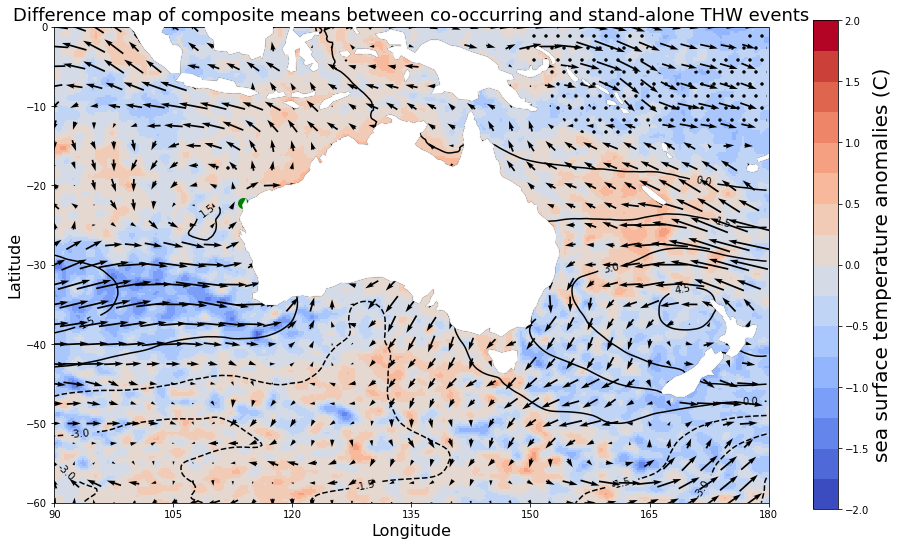

In [47]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=diff_ssta.plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-2, vmax=2, # Minimum and maximum values of the colormap
       )

ploteo2=diff_mslpa.plot.contour(
            #cmap=plt.cm.get_cmap('coolwarm', 12), # Specify the colourmap of interest and also the number of discrete levels. I have 5, corresponding to the number of MHW severity categories. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for examples
            #cmap=cmocean.cm.diff,
            #vmin=-10, vmax=10, # Minimum and maximum values of the colormap
            colors='k',
            levels=10
       )

ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ploteo.colorbar.ax.set_ylabel('sea surface temperature anomalies (C)',fontsize=20)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
ax.quiver(x[::10], y[::10], diff_uwind[::10, ::10], diff_vwind[::10, ::10], pivot='middle')
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='none', add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Difference map of composite means between co-occurring and stand-alone THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/mslpa-diff.png')

## SLHF anomalies

In [48]:
## surface latent heat flux 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/slhf_anom.nc')
slhf = ds.slhf_anomaly 

In [49]:
## windspeed anomalies

wind_speed = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/windspeed_anom.nc')
wind_speed_anom = wind_speed.windspeed_anomaly

In [50]:
slhfa_co = xr.DataArray(np.zeros((co_events.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_co['lat'] = slhf['latitude'].values
slhfa_co['lon'] = slhf['longitude'].values
slhfa_co['event'] = co_events.index.values

for i, e in enumerate(co_events.itertuples()):
    slhfa_co[i, :, :] = slhf.sel(time=slice(e.time, e.time_end)).mean('time')

In [51]:
ws_co = xr.DataArray(np.zeros((co_events.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_co['lat'] = wind_speed_anom['latitude'].values
ws_co['lon'] = wind_speed_anom['longitude'].values
ws_co['event'] = co_events.index.values

for i, e in enumerate(co_events.itertuples()):
    ws_co[i, :, :] = wind_speed_anom.sel(time=slice(e.time, e.time_end)).mean('time')

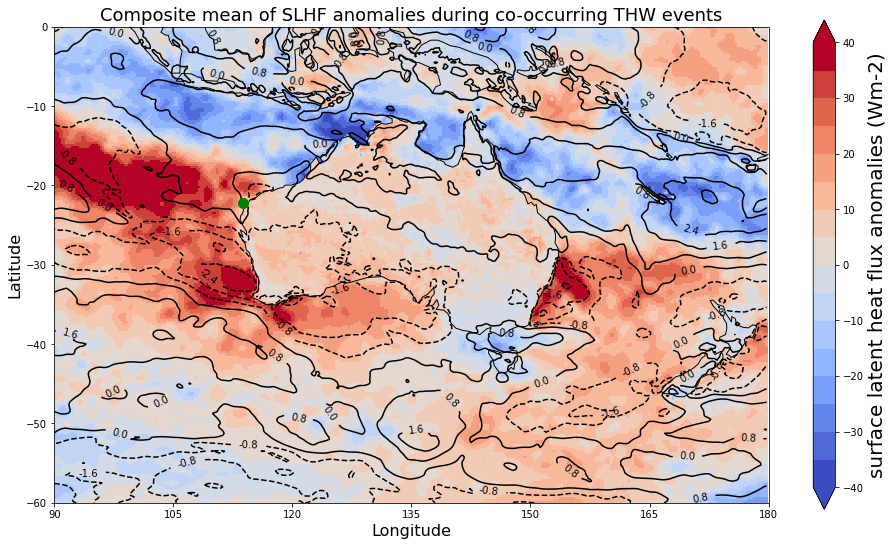

In [52]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=slhfa_co.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40.0, vmax=40.0, # Minimum and maximum values of the colormap
       )

ploteo2=ws_co.mean(dim='event').plot.contour(
            colors='k',
            levels=10
       )
ploteo.colorbar.ax.set_ylabel('surface latent heat flux anomalies (Wm-2)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of SLHF anomalies during co-occurring THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/slhfa-co.png')

In [53]:
slhfa_nco = xr.DataArray(np.zeros((stand_alone.shape[0], slhf.shape[1], slhf.shape[2])), dims=['event', 'lat', 'lon'])
slhfa_nco['lat'] = slhf['latitude'].values
slhfa_nco['lon'] = slhf['longitude'].values
slhfa_nco['event'] = stand_alone.index.values
    
for i, e in enumerate(stand_alone.itertuples()):
    slhfa_nco[i, :, :] = slhf.sel(time=slice(e.time, e.time_end)).mean('time')

In [54]:
ws_nco = xr.DataArray(np.zeros((stand_alone.shape[0], wind_speed_anom.shape[1], wind_speed_anom.shape[2])), dims=['event', 'lat', 'lon'])
ws_nco['lat'] = wind_speed_anom['latitude'].values
ws_nco['lon'] = wind_speed_anom['longitude'].values
ws_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ws_nco[i, :, :] = wind_speed_anom.sel(time=slice(e.time, e.time_end)).mean('time')

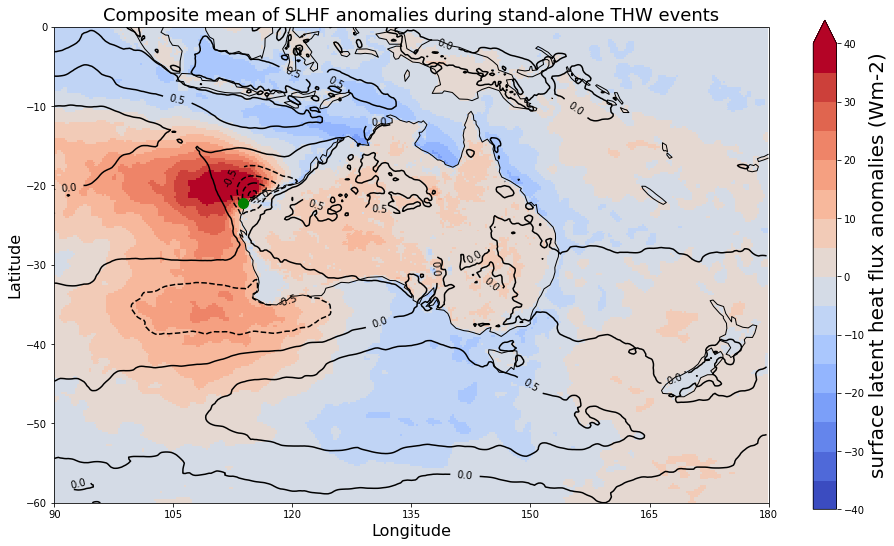

In [55]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=slhfa_nco.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40.0, vmax=40.0, # Minimum and maximum values of the colormap
       )

ploteo2=ws_nco.mean(dim='event').plot.contour(
            colors='k',
            levels=10
       )
ploteo.colorbar.ax.set_ylabel('surface latent heat flux anomalies (Wm-2)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of SLHF anomalies during stand-alone THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/slhfa-nco.png')

In [56]:
diff_slhfa = slhfa_co.mean(dim='event') - slhfa_nco.mean(dim='event')
diff_ws = ws_co.mean(dim='event') - ws_nco.mean(dim='event')

In [57]:
# run the Welch's T-Test
r = stats.ttest_ind(slhfa_co, slhfa_nco, axis=0, equal_var=False, nan_policy='omit')

In [58]:
# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('lat', 'lon'), coords={
    'lat': slhfa_co['lat'],
    'lon': slhfa_co['lon']
})

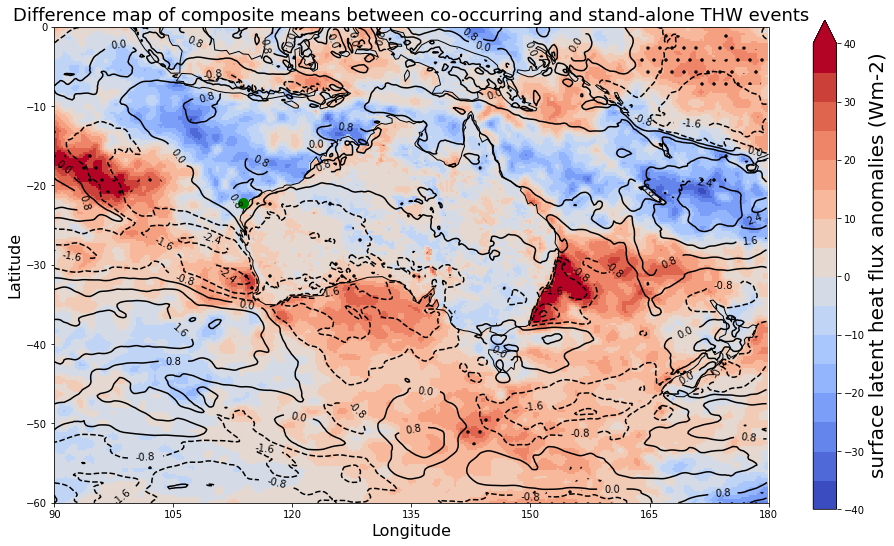

In [59]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=diff_slhfa.plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40, vmax=40, # Minimum and maximum values of the colormap
       )

ploteo2=diff_ws.plot.contour(
            #cmap=plt.cm.get_cmap('coolwarm', 12), # Specify the colourmap of interest and also the number of discrete levels. I have 5, corresponding to the number of MHW severity categories. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for examples
            #cmap=cmocean.cm.diff,
            #vmin=-10, vmax=10, # Minimum and maximum values of the colormap
            colors='k',
            levels=10
       )

ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ploteo.colorbar.ax.set_ylabel('surface latent heat flux anomalies (Wm-2)',fontsize=20)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='none', add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Difference map of composite means between co-occurring and stand-alone THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/slhfa-diff.png')

## Shortwave radiation anomalies 

In [60]:
## shortwave radiation 

ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/ssr_anom.nc')
ssr = ds.ssr_anomaly 

In [61]:
ssra_co = xr.DataArray(np.zeros((co_events.shape[0], ssr.shape[1], ssr.shape[2])), dims=['event', 'lat', 'lon'])
ssra_co['lat'] = ssr['latitude'].values
ssra_co['lon'] = ssr['longitude'].values
ssra_co['event'] = co_events.index.values

for i, e in enumerate(co_events.itertuples()):
    ssra_co[i, :, :] = ssr.sel(time=slice(e.time, e.time_end)).mean('time')

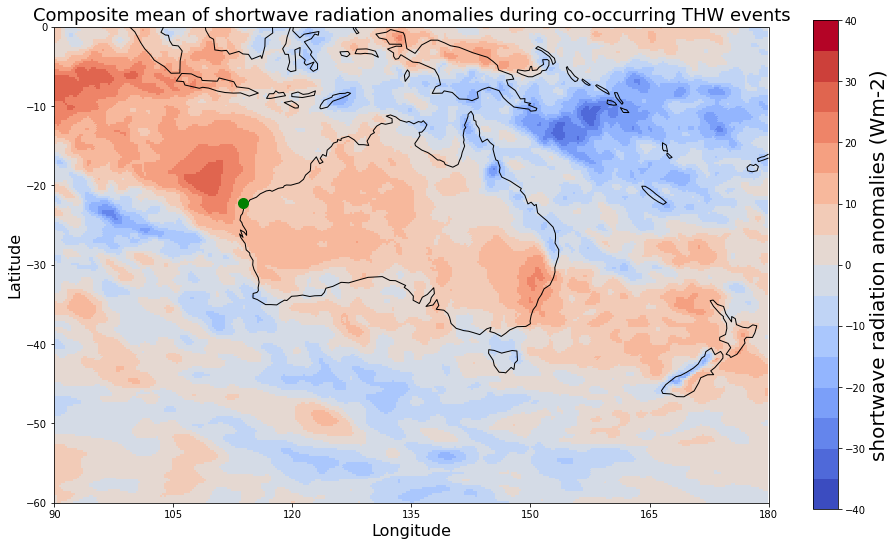

In [62]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=ssra_co.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40.0, vmax=40.0, # Minimum and maximum values of the colormap
       )

ploteo.colorbar.ax.set_ylabel('shortwave radiation anomalies (Wm-2)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of shortwave radiation anomalies during co-occurring THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/ssra-co.png')

In [63]:
ssra_nco = xr.DataArray(np.zeros((stand_alone.shape[0], ssr.shape[1], ssr.shape[2])), dims=['event', 'lat', 'lon'])
ssra_nco['lat'] = ssr['latitude'].values
ssra_nco['lon'] = ssr['longitude'].values
ssra_nco['event'] = stand_alone.index.values

for i, e in enumerate(stand_alone.itertuples()):
    ssra_nco[i, :, :] = ssr.sel(time=slice(e.time, e.time_end)).mean('time')

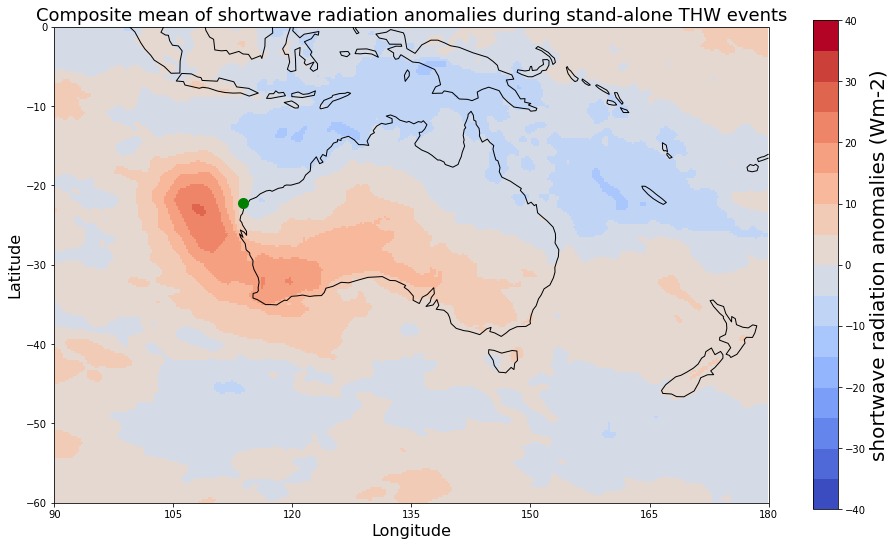

In [64]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=ssra_nco.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40.0, vmax=40.0, # Minimum and maximum values of the colormap
       )

ploteo.colorbar.ax.set_ylabel('shortwave radiation anomalies (Wm-2)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of shortwave radiation anomalies during stand-alone THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/ssra-nco.png')

In [65]:
diff_ssra = ssra_co.mean(dim='event') - ssra_nco.mean(dim='event')

In [66]:
# run the Welch's T-Test
r = stats.ttest_ind(ssra_co, ssra_nco, axis=0, equal_var=False, nan_policy='omit')

In [67]:
# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('lat', 'lon'), coords={
    'lat': ssra_co['lat'],
    'lon': ssra_co['lon']
})

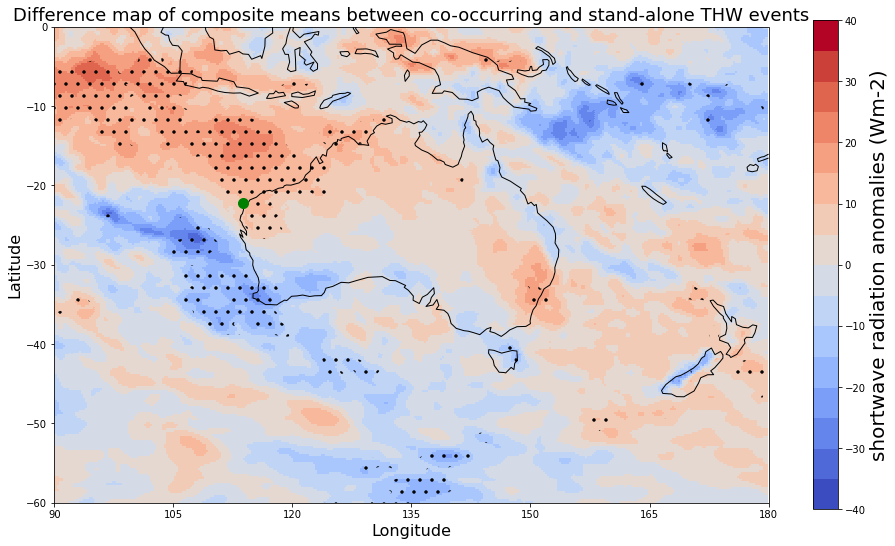

In [68]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=diff_ssra.plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40, vmax=40, # Minimum and maximum values of the colormap
       )

ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ploteo.colorbar.ax.set_ylabel('shortwave radiation anomalies (Wm-2)',fontsize=20)
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
da.plot.contourf(levels=[0.00, 0.05], hatches=['.', None], colors='none', add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Difference map of composite means between co-occurring and stand-alone THW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/ssra-diff.png')

## Stand-alone MHW

In [72]:
#a stand-alone MHW event is a MHW which does not overlap with a THW event 

# concatenating the MHW and THW dataframes 
df_merge_mhw = pd.concat([mhw_new, thw_new_H], axis=1)
df_merge_mhw

,time_mhw,time_end_mhw,event_duration_mhw,time,time_end,event_duration
0,1982-03-16,1982-03-20,5.0,1982-01-16,1982-01-18,3
1,1982-04-29,1982-05-10,12.0,1982-05-10,1982-05-12,3
2,1982-08-07,1982-08-21,15.0,1982-08-20,1982-08-22,3
3,1982-10-17,1982-10-25,9.0,1982-11-28,1982-12-01,4
4,1982-11-20,1982-12-08,19.0,1983-05-28,1983-05-30,3
...,...,...,...,...,...,...
183,NaT,NaT,NaN,2018-03-07,2018-03-11,5
184,NaT,NaT,NaN,2018-04-04,2018-04-06,3
185,NaT,NaT,NaN,2018-08-17,2018-08-19,3
186,NaT,NaT,NaN,2018-09-23,2018-09-25,3


In [73]:
#Calculating the overlap between THW and MHW events 
from datetime import datetime
from collections import namedtuple
Range = namedtuple('Range', ['start', 'end'])
overlap = []
for n in range (df_merge_mhw.shape[0]):
    mhw = Range(start=df_merge_mhw['time_mhw'].iloc[n], end=df_merge_mhw['time_end_mhw'].iloc[n])
    thw = Range(start=df_merge_mhw['time'].iloc[n], end=df_merge_mhw['time_end'].iloc[n])
    latest_start = max(mhw.start, thw.start)
    earliest_end = min(mhw.end, thw.end)
    delta = (earliest_end - latest_start).days + 1
    b = max(0, delta)
    overlap.append(b)

In [74]:
mod_mhw = df_merge_mhw.assign(overlap_days = overlap)
mod_mhw

,time_mhw,time_end_mhw,event_duration_mhw,time,time_end,event_duration,overlap_days
0,1982-03-16,1982-03-20,5.0,1982-01-16,1982-01-18,3,0
1,1982-04-29,1982-05-10,12.0,1982-05-10,1982-05-12,3,1
2,1982-08-07,1982-08-21,15.0,1982-08-20,1982-08-22,3,2
3,1982-10-17,1982-10-25,9.0,1982-11-28,1982-12-01,4,0
4,1982-11-20,1982-12-08,19.0,1983-05-28,1983-05-30,3,0
...,...,...,...,...,...,...,...
183,NaT,NaT,NaN,2018-03-07,2018-03-11,5,0
184,NaT,NaT,NaN,2018-04-04,2018-04-06,3,0
185,NaT,NaT,NaN,2018-08-17,2018-08-19,3,0
186,NaT,NaT,NaN,2018-09-23,2018-09-25,3,0


In [83]:
mhw_only = mod_mhw[mod_mhw.overlap_days == 0].reset_index()
mhw_only

,index,time_mhw,time_end_mhw,event_duration_mhw,time,time_end,event_duration,overlap_days
0,0,1982-03-16,1982-03-20,5.0,1982-01-16,1982-01-18,3,0
1,3,1982-10-17,1982-10-25,9.0,1982-11-28,1982-12-01,4,0
2,4,1982-11-20,1982-12-08,19.0,1983-05-28,1983-05-30,3,0
3,5,1983-01-11,1983-01-17,7.0,1983-08-06,1983-08-10,5,0
4,6,1983-06-10,1983-06-15,6.0,1983-09-17,1983-09-20,4,0
...,...,...,...,...,...,...,...,...
175,183,NaT,NaT,NaN,2018-03-07,2018-03-11,5,0
176,184,NaT,NaT,NaN,2018-04-04,2018-04-06,3,0
177,185,NaT,NaT,NaN,2018-08-17,2018-08-19,3,0
178,186,NaT,NaT,NaN,2018-09-23,2018-09-25,3,0


In [84]:
stand_alone_mhw = mhw_only.dropna()
stand_alone_mhw

,index,time_mhw,time_end_mhw,event_duration_mhw,time,time_end,event_duration,overlap_days
0,0,1982-03-16,1982-03-20,5.0,1982-01-16,1982-01-18,3,0
1,3,1982-10-17,1982-10-25,9.0,1982-11-28,1982-12-01,4,0
2,4,1982-11-20,1982-12-08,19.0,1983-05-28,1983-05-30,3,0
3,5,1983-01-11,1983-01-17,7.0,1983-08-06,1983-08-10,5,0
4,6,1983-06-10,1983-06-15,6.0,1983-09-17,1983-09-20,4,0
...,...,...,...,...,...,...,...,...
117,125,2016-12-15,2016-12-22,8.0,2010-10-02,2010-10-04,3,0
118,126,2017-02-26,2017-03-09,12.0,2010-10-06,2010-10-09,4,0
119,127,2017-09-12,2017-09-17,6.0,2010-10-14,2010-10-16,3,0
120,128,2018-01-17,2018-01-22,6.0,2010-10-18,2010-10-23,6,0


In [85]:
del stand_alone_mhw['time']
del stand_alone_mhw['time_end']
del stand_alone_mhw['overlap_days']
del stand_alone_mhw['event_duration']

stand_alone_mhw

,index,time_mhw,time_end_mhw,event_duration_mhw
0,0,1982-03-16,1982-03-20,5.0
1,3,1982-10-17,1982-10-25,9.0
2,4,1982-11-20,1982-12-08,19.0
3,5,1983-01-11,1983-01-17,7.0
4,6,1983-06-10,1983-06-15,6.0
...,...,...,...,...
117,125,2016-12-15,2016-12-22,8.0
118,126,2017-02-26,2017-03-09,12.0
119,127,2017-09-12,2017-09-17,6.0
120,128,2018-01-17,2018-01-22,6.0


In [86]:
ssra_mhw = xr.DataArray(np.zeros((stand_alone_mhw.shape[0], ssr.shape[1], ssr.shape[2])), dims=['event', 'lat', 'lon'])
ssra_mhw['lat'] = ssr['latitude'].values
ssra_mhw['lon'] = ssr['longitude'].values
ssra_mhw['event'] = stand_alone_mhw.index.values

for i, e in enumerate(co_events.itertuples()):
    ssra_mhw[i, :, :] = ssr.sel(time=slice(e.time, e.time_end)).mean('time')

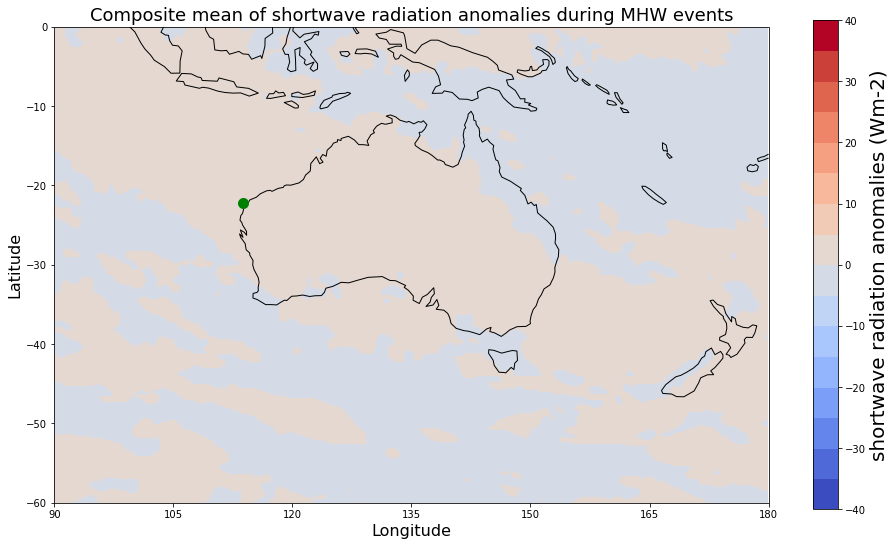

In [87]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, zorder=100, facecolor='white')
ploteo=ssra_mhw.mean(dim='event').plot(
            cmap=plt.cm.get_cmap('coolwarm', 16), 
            vmin=-40.0, vmax=40.0, # Minimum and maximum values of the colormap
       )

ploteo.colorbar.ax.set_ylabel('shortwave radiation anomalies (Wm-2)',fontsize=20)
ax.clabel(ploteo2, inline=True, fontsize=10, fmt='%1.1f')
ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.title('Composite mean of shortwave radiation anomalies during MHW events', fontsize=18)
plt.plot(113.75, -22.25,  markersize=10, marker='o', color='green')
plt.show()
#plt.savefig('/g/data/e14/cp3790/Charuni/Plots/ssra-mhw.png')